                           spot_price  spot_price_target_t+1  \
datetime_utc                                                   
2016-06-30 00:00:00+00:00   23.192917              22.667083   
2016-07-01 00:00:00+00:00   22.667083              20.751250   
2016-07-02 00:00:00+00:00   20.751250              20.066667   
2016-07-03 00:00:00+00:00   20.066667              22.660833   
2016-07-04 00:00:00+00:00   22.660833              22.177500   

                           spot_price_target_t+2  spot_price_target_t+3  \
datetime_utc                                                              
2016-06-30 00:00:00+00:00              20.751250              20.066667   
2016-07-01 00:00:00+00:00              20.066667              22.660833   
2016-07-02 00:00:00+00:00              22.660833              22.177500   
2016-07-03 00:00:00+00:00              22.177500              20.221667   
2016-07-04 00:00:00+00:00              20.221667              22.787083   

                         

/Users/andersrodem/Documents/Progging/anvendt-data-science/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/andersrodem/Documents/Progging/anvendt-data-science/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted t+1: 28.957277361885463, Expected: 40.82875
Predicted t+1: 32.36962158531989, Expected: 29.299166666666665
Predicted t+1: 27.724303240438545, Expected: 26.72583333333333
Predicted t+1: 30.352676932332642, Expected: 40.0075
Predicted t+1: 38.08131363241147, Expected: 31.58791666666667
Predicted t+1: 30.078283725117874, Expected: 32.294999999999995
Predicted t+1: 38.88095013296605, Expected: 32.29125
Predicted t+1: 35.90850039872305, Expected: 40.44916666666666
Predicted t+1: 40.05252361313799, Expected: 40.389583333333334
Forecast t+1:
MAE: 4.299974135042069

Forecast t+2:
MAE: 4.3714172709604275

Forecast t+3:
MAE: 4.361278834376502

Forecast t+4:
MAE: 4.437413633090785

Forecast t+5:
MAE: 4.323629631583362

Forecast t+6:
MAE: 4.148944944259794

Forecast t+7:
MAE: 4.395358844052449

Average MAE for all 7 days: 4.33400247048077


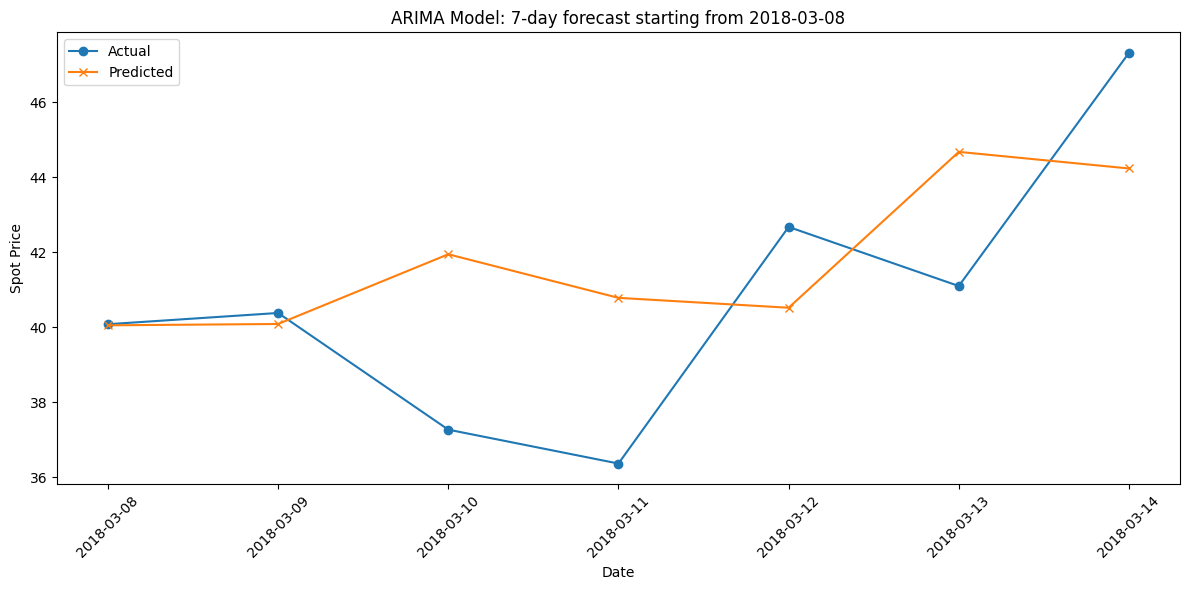

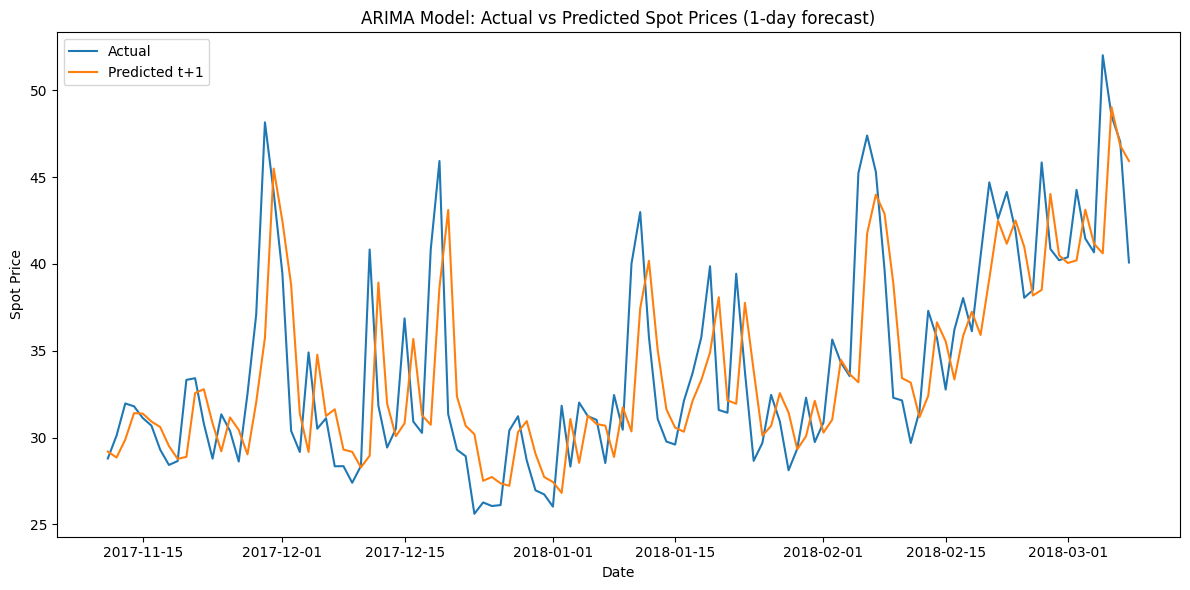

In [6]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Cell 2: Load the prepared data
features = pd.read_csv('prepared_data/prepared_features.csv', index_col='datetime_utc', parse_dates=True)
targets = pd.read_csv('prepared_data/prepared_targets.csv', index_col='datetime_utc', parse_dates=True)

# Load the original data to get the unscaled spot_price
original_data = pd.read_csv('Datasets/data_NO2.csv', sep=';', parse_dates=['datetime_utc'])
original_data.set_index('datetime_utc', inplace=True)
original_data = original_data.resample('D').mean()

# Replace the scaled spot_price with the original unscaled version
features['spot_price'] = original_data['spot_price']

# Combine spot_price from features with targets
data = pd.concat([features['spot_price'], targets], axis=1)
print(data.head())

# Cell 3: Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Cell 4: Define a function to evaluate the model
def evaluate_model(predictions, actual):
    mae = mean_absolute_error(actual, predictions)
    return mae

# Cell 5: Implement ARIMA model for 7-day ahead prediction
def arima_forecast(history, order, steps=7):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast(steps=steps)
    return output

# Cell 6: Make predictions using ARIMA
history = [x for x in train['spot_price']]
predictions = {f't+{i}': [] for i in range(1, 8)}

for t in range(len(test) - 7):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast(steps=7)
    for i, pred in enumerate(output):
        predictions[f't+{i+1}'].append(pred)
    obs = test['spot_price'].iloc[t]
    history.append(obs)
    if t % 10 == 0:  # Print every 10th prediction to reduce output
        print(f'Predicted t+1: {output[0]}, Expected: {obs}')

# Cell 7: Evaluate the ARIMA model for each forecast horizon
for i in range(1, 8):
    actual = test[f'spot_price_target_t+{i}'].iloc[:-7]
    pred = predictions[f't+{i}']
    mae = evaluate_model(pred, actual)
    print(f'Forecast t+{i}:')
    print(f'MAE: {mae}')
    print()

# Calculate average MAE for all 7 days
average_mae = np.mean([evaluate_model(predictions[f't+{i}'], test[f'spot_price_target_t+{i}'].iloc[:-7]) for i in range(1, 8)])
print(f"Average MAE for all 7 days: {average_mae}")

# Cell 8: Plot the results for a specific date
selected_date = test.index[-8]  # Choose a date that has 7 days of predictions
actual_values = test['spot_price'].loc[selected_date:selected_date + pd.Timedelta(days=6)]
predicted_values = [predictions[f't+{i}'][-8+i-1] for i in range(1, 8)]

plt.figure(figsize=(12,6))
plt.plot(actual_values.index, actual_values, label='Actual', marker='o')
plt.plot(actual_values.index, predicted_values, label='Predicted', marker='x')
plt.title(f'ARIMA Model: 7-day forecast starting from {selected_date.date()}')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional plot for the entire test period
plt.figure(figsize=(12,6))
plt.plot(test.index[:-7], test['spot_price'].iloc[:-7], label='Actual')
plt.plot(test.index[:-7], predictions['t+1'], label='Predicted t+1')
plt.title('ARIMA Model: Actual vs Predicted Spot Prices (1-day forecast)')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.legend()
plt.tight_layout()
plt.show()